# Import Modules

First, we are going to load the relevant libraries into the notebook



In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras import backend as K
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dropout,BatchNormalization
from keras.layers import Dense,Convolution2D, MaxPooling2D, GlobalAveragePooling2D,Flatten
from keras.optimizers import SGD
from matplotlib import pyplot as plt
import seaborn as sns 
sns.set(color_codes = True)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/home/hf/anaconda2/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Specify Parameters

In [2]:
#Input image dimensions
img_rows, img_cols = 32, 32
num_classes = 10
batch_size = 64
epochs = 10

# Load the Data

Second, We are going to load the CIFAR10 dataset and format the images for CNN.

In [3]:
#The data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Shape of training set
print("Training images shape: {shape}".format(shape=x_train.shape))
print("Training labels shape: {shape}".format(shape=y_train.shape))

# Shapes of test set
print("Test images shape: {shape}".format(shape=x_test.shape))
print("Test labels shape: {shape}".format(shape=y_test.shape))

Training images shape: (50000, 32, 32, 3)
Training labels shape: (50000, 1)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


##  Plot input data - 10 random images from each class

In [4]:
class_names = ['airplane','automobile','bird','cat','deer',
               'dog','frog','horse','ship','truck']

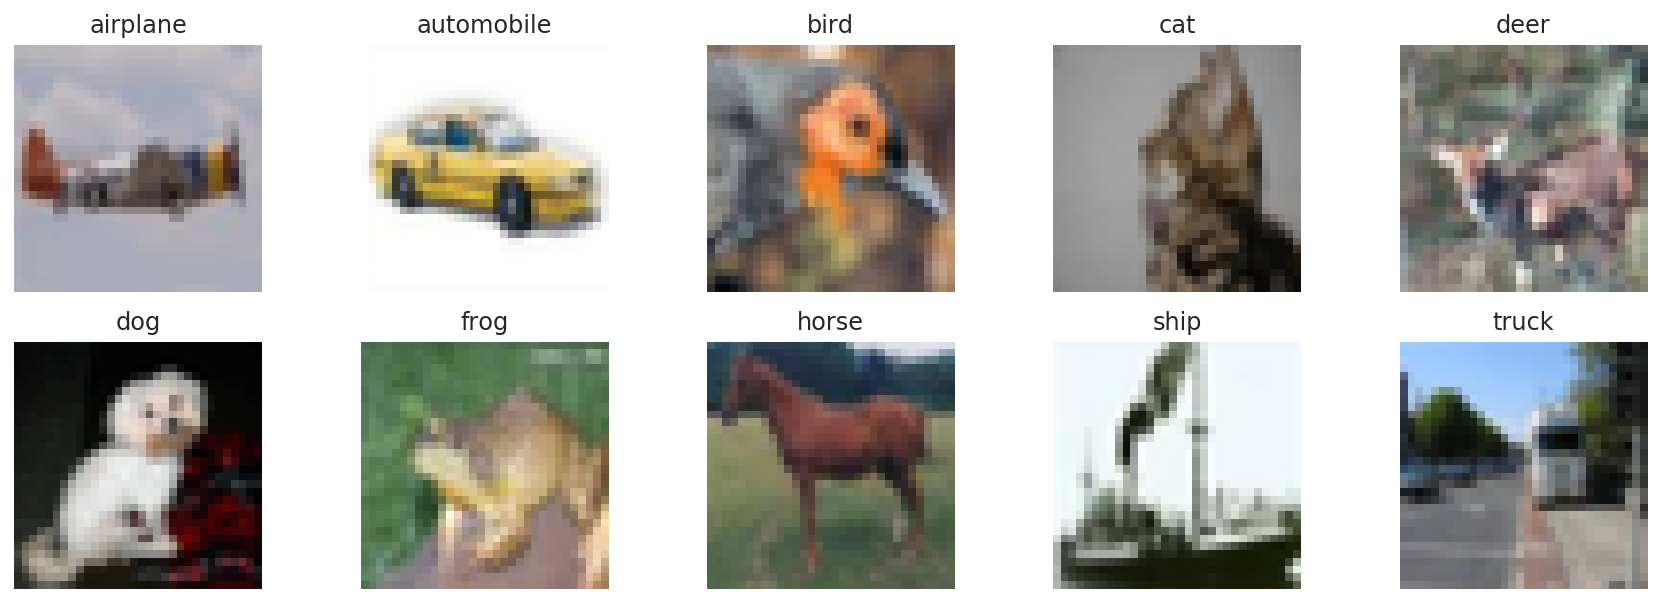

In [5]:
fig = plt.figure(figsize=(15,5))
for i in range(num_classes):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    
    im = np.transpose(features_idx[img_num,:,:], (0, 1, 2))
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show()

## Preprocessiong the data

In [6]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 3, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 3, img_rows, img_cols)
    input_shape = (3, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 3)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 3)
    input_shape = (img_rows, img_cols, 3)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
#Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(np.ravel(y_train), num_classes)
y_test = keras.utils.to_categorical(np.ravel(y_test), num_classes)
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)

50000 train samples
10000 test samples
x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 10)


# Use Keras ImageDataGenerator() for data augmentation

In [7]:
# Initialize Generator
datagen = ImageDataGenerator(rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

# fit parameters from data
datagen.fit(x_train)

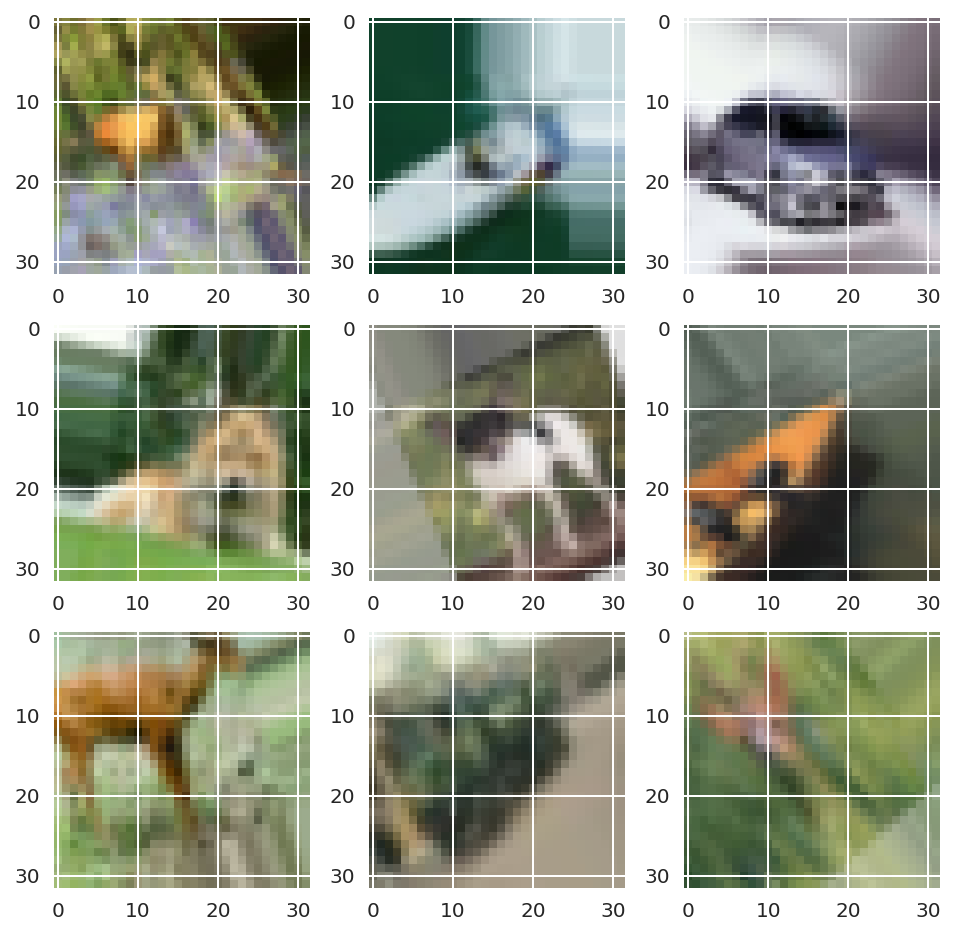

In [8]:
# Configure batch size and retrieve one batch of images
plt.figure(figsize =(8,8))
for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9):
    # Show the first 9 images
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(x_batch[i].reshape(img_rows, img_cols, 3))
    # show the plot
    plt.show()
    break

# Train and Validate the Model with CNN

## Plot Model Training Progress

In [9]:
def plot_model_training(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

## Design, Compile and Train your Keras model 

In [10]:
model = Sequential()
model.add(Convolution2D(32,(3,3), strides = (1, 1),activation = 'relu', input_shape=input_shape))
model.add(BatchNormalization(axis =3))

model.add(Convolution2D(64,(3,3), strides = (1, 1),activation = 'relu'))
model.add(BatchNormalization(axis =3))

model.add(Convolution2D(128,(3,3), strides = (1, 1),activation = 'relu'))
model.add(BatchNormalization(axis =3))
model.add(MaxPooling2D(pool_size =(2,2)))

model.add(Convolution2D(256, (3,3), activation='relu'))
model.add(BatchNormalization(axis =3))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(10,activation ='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 64)        256       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 26, 26, 128)       73856     
_________________________________________________________________
batch_normalization_3 (Batch (None, 26, 26, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 128)       0         
__________

In [11]:
#Compilation
model.compile(optimizer = 'nadam', loss = 'categorical_crossentropy',metrics = ['accuracy'])

In [12]:
#Train & Evaluate Model
history= model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        epochs=epochs,
                        validation_data = (x_test[:5000], y_test[:5000]))

Epoch 1/10
781/781 [==============================] - 27s 34ms/step - loss: 1.8134 - acc: 0.3545 - val_loss: 2.0574 - val_acc: 0.3636
Epoch 2/10
781/781 [==============================] - 25s 32ms/step - loss: 1.4395 - acc: 0.4882 - val_loss: 1.2974 - val_acc: 0.5500
Epoch 3/10
781/781 [==============================] - 25s 32ms/step - loss: 1.3010 - acc: 0.5421 - val_loss: 1.3530 - val_acc: 0.5108
Epoch 4/10
781/781 [==============================] - 25s 32ms/step - loss: 1.2078 - acc: 0.5770 - val_loss: 1.2800 - val_acc: 0.5538
Epoch 5/10
781/781 [==============================] - 25s 32ms/step - loss: 1.1501 - acc: 0.5984 - val_loss: 1.0706 - val_acc: 0.6380
Epoch 6/10
781/781 [==============================] - 25s 32ms/step - loss: 1.0876 - acc: 0.6211 - val_loss: 1.1284 - val_acc: 0.6280
Epoch 7/10
781/781 [==============================] - 25s 32ms/step - loss: 1.0348 - acc: 0.6396 - val_loss: 1.1095 - val_acc: 0.6182
Epoch 8/10
781/781 [==============================] - 25s 32ms

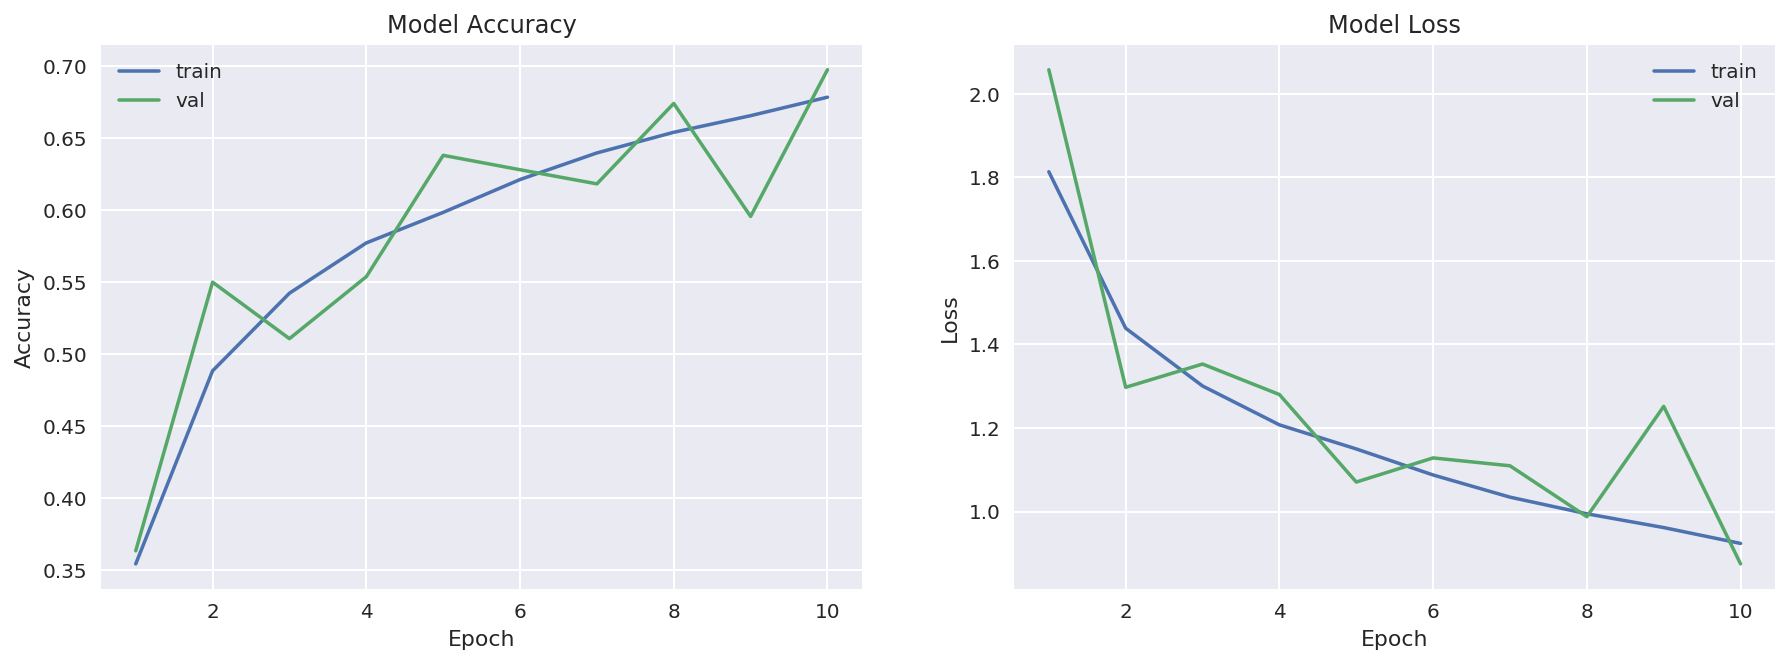

In [13]:
plot_model_training(history)

In [14]:
#evaluate test accuracy
socres,acc = model.evaluate(x_test[5000:],y_test[5000:],
                            batch_size = batch_size,
                            verbose=1)
print('Test Accuracy: %.2f%%' % (acc*100))

5000/5000 [==============================] - 1s 171us/step
Test Accuracy: 69.44%


# Further investigation (OPTIONAL)

## Confusion Matrix

**Confusion Matrix** is also known as $error$ $matrix$ is a specific table layout that allows visualiztion of the performance of an algorithm. Each row of the matrix represents the instance in a predicted class while each column represents the instance in a actual class. 

0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000
[[608  76  22  37  21   3  19  39 124  51]
 [  3 876   0  17   2   0   7   7  39  49]
 [ 42  18 408 108  81  16 232  61  21  13]
 [ 11   8  22 631  44  78 148  30  15  13]
 [  7   2  14  68 601  13 188  97   7   3]
 [  3  14  16 208  49 549  82  54   8  17]
 [  4   3  11  45  37   3 874  13   5   5]
 [  4  10   7  72  56  26  36 773   5  11]
 [ 25  23   7  19   6   0  14   3 891  12]
 [ 18 111   1  38   6   0  30  13  35 748]]


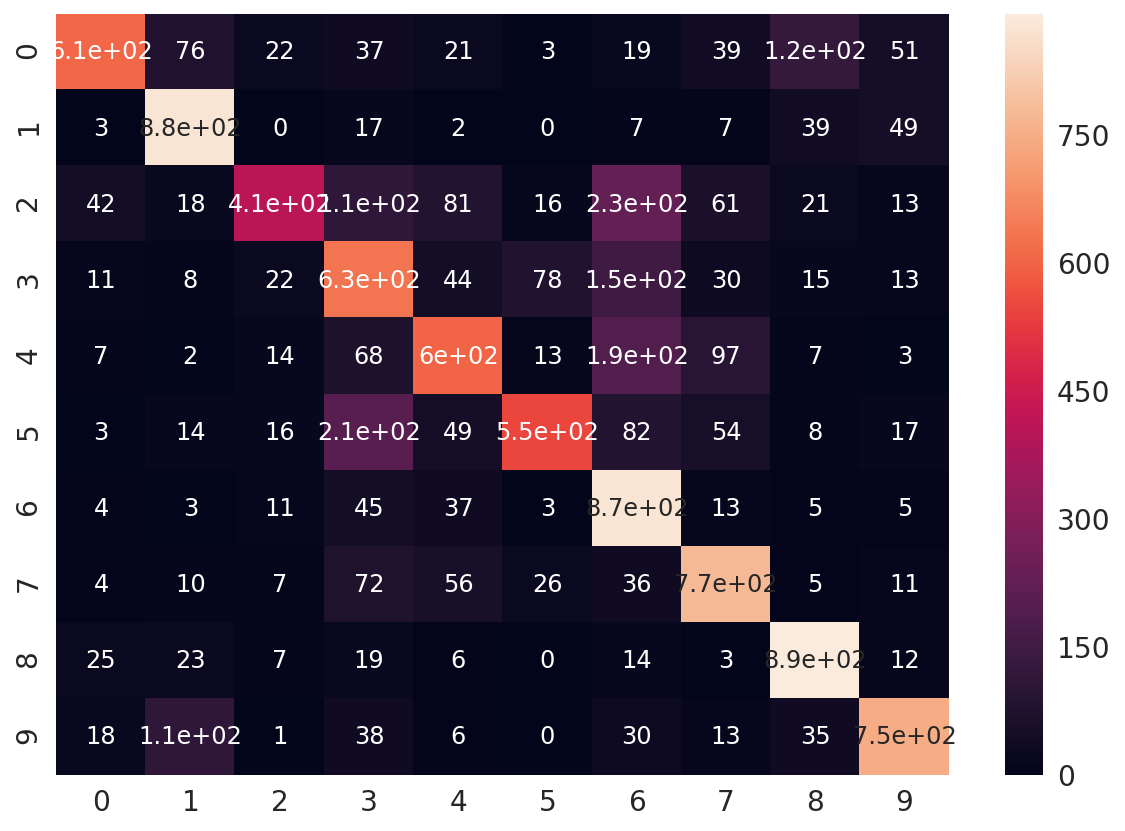

In [15]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(x_test, verbose=2)
y_pred = np.argmax(Y_pred, axis=1)
 
for ix in range(10):
    print(ix, confusion_matrix(np.argmax(y_test,axis=1),y_pred)[ix].sum())
cm = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
print(cm)
 
# Visualizing of confusion matrix
import seaborn as sn
import pandas  as pd
 
 
df_cm = pd.DataFrame(cm, range(10),
                  range(10))
plt.figure(figsize = (10,7))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, annot=True,annot_kws={"size": 12})# font size
plt.show()